# Exploring the use of Animal Faces dataset

### Importing Libraries
<code style="color:darkblue">
- numpy: computiong library for large/multidimensioanl array & functions
- pandas: data analysis & data manipulation</code>

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2024-06-10 23:18:46.340692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 23:18:46.340814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 23:18:46.469532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


***
# Importing Dataset from Kaggle and Preprocessing Data

## Loading data and training data

In [3]:
classes = {"cat": "1", "dog": "2", "wild": "3"}
allFilenames = []
allCategories = []
for classElement in classes:
    filenames = os.listdir("/kaggle/input/animal-faces/afhq/train/"+classElement)
    allFilenames += [classElement + "/" + file for file in filenames]
    allCategories += [classes[classElement]] * len(filenames)


df = pd.DataFrame({
    'filename': allFilenames,
    'class': allCategories
})

## Loading Test Data

In [4]:
allFilenames_test = []
allCategories_test = []
for classElement in classes:
    filenames = os.listdir("/kaggle/input/animal-faces/afhq/train/" + classElement)
    allFilenames_test += [classElement + "/" + file for file in filenames]
    allCategories_test += [classes[classElement]] * len(filenames)


df_test = pd.DataFrame({
    'filename': allFilenames_test,
    'class': allCategories_test
})

In [5]:
df.head()

,filename,class
0,cat/pixabay_cat_000354.jpg,1
1,cat/pixabay_cat_002763.jpg,1
2,cat/pixabay_cat_001283.jpg,1
3,cat/pixabay_cat_003423.jpg,1
4,cat/flickr_cat_000496.jpg,1


## Splitting Data

In [6]:
df_training, df_validation = train_test_split(df, test_size = 0.20)
df_training = df_training.reset_index(drop = True)
df_validation = df_validation.reset_index(drop = True)

In [7]:
df_training

,filename,class
0,dog/pixabay_dog_002184.jpg,2
1,cat/pixabay_cat_002590.jpg,1
2,cat/pixabay_cat_003898.jpg,1
3,cat/pixabay_cat_001252.jpg,1
4,cat/pixabay_cat_001695.jpg,1
...,...,...
11699,cat/pixabay_cat_002422.jpg,1
11700,wild/flickr_wild_002374.jpg,3
11701,wild/flickr_wild_000312.jpg,3
11702,wild/pixabay_wild_000407.jpg,3


## Training Data Generator

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.2,  
    height_shift_range = 0.2,    
    zoom_range = 0.2,        
    horizontal_flip = True, 
    rescale = 1./255,
    fill_mode = 'reflect'
)

train_generator = train_datagen.flow_from_dataframe(
    df_training, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 11704 validated image filenames belonging to 3 classes.


## Example Data Visualization

In [9]:
df_example = df_training.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col='filename',
    y_col='class',
    target_size = (150, 150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


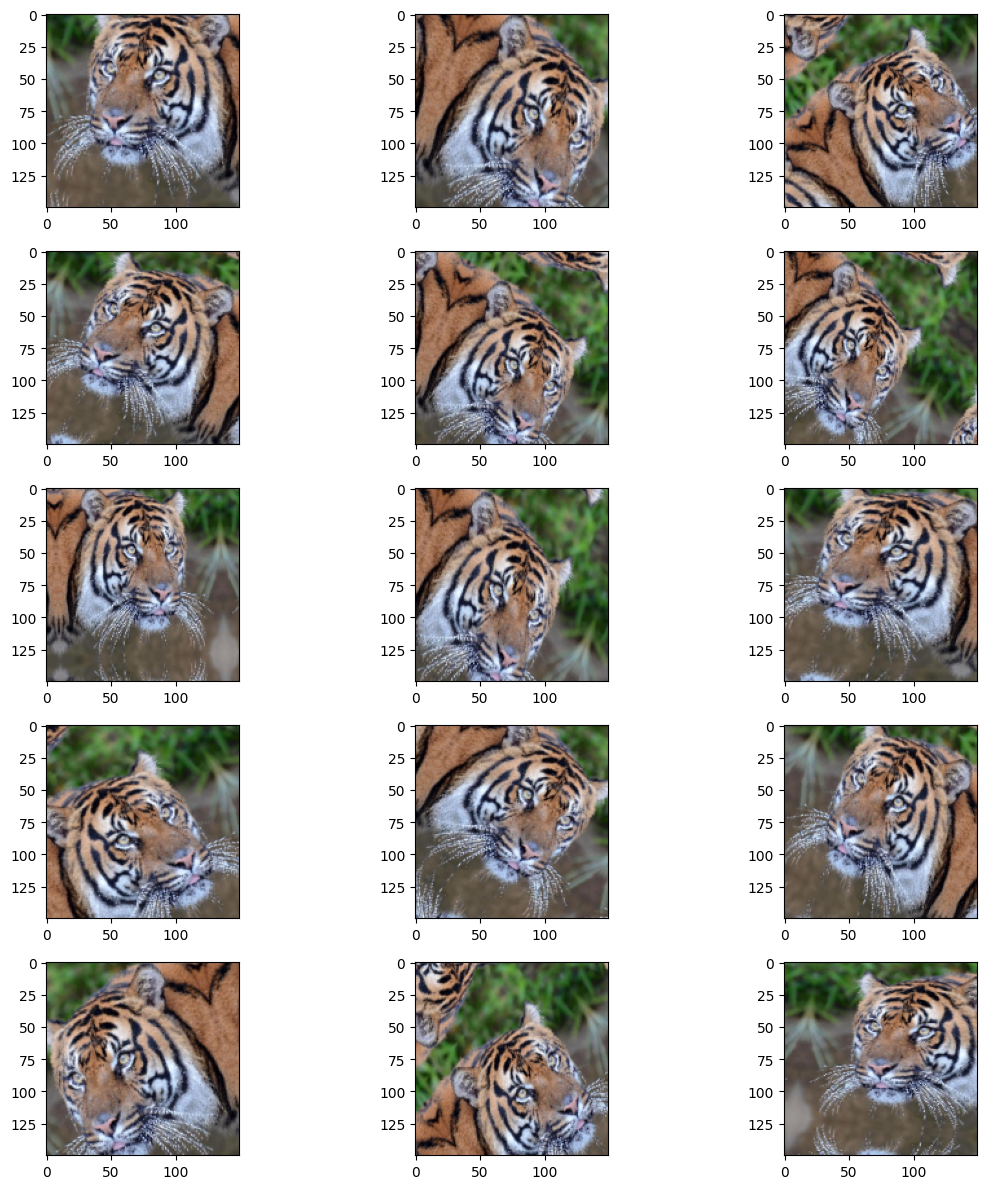

In [10]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Validation Data Generator

In [11]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_validation, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 2926 validated image filenames belonging to 3 classes.


***
# Building the Convolutional Neural Networks (CNNs) model

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

In [13]:
early_stopping = EarlyStopping(patience=10)

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, factor = 0.5, min_lr = 0.00001)

callbacks = [early_stopping, reduce_lr]

***
# Training the model

<code style="color:darkblue">In every train dataset cat, dog and wild we have around 821 pictures that are called flickr_cat, flickr_dog or flickr_wild and around 4834 pixabay_cat, pixabay_dog or pixabay_wild. Overall in the dataset I have around 5655 images for cat, around 5655 images for dog and around 5655 images for wild animal. Every image has 512×512 resolution. </code>

In [14]:
history = model.fit(
    train_generator, 
    epochs = 10,
    validation_data = validation_generator,
    callbacks = callbacks
)

Epoch 1/10


2024-06-10 23:19:14.412318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718061558.937341      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 [==============================] - 141s 733ms/step - loss: 1.0594 - accuracy: 0.6066 - val_loss: 3.9555 - val_accuracy: 0.3377 - lr: 0.0010
Epoch 2/10
183/183 [==============================] - 91s 495ms/step - loss: 0.6012 - accuracy: 0.7579 - val_loss: 2.2193 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 3/10
183/183 [==============================] - 90s 492ms/step - loss: 0.4449 - accuracy: 0.8242 - val_loss: 1.3401 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 4/10
183/183 [==============================] - 92s 500ms/step - loss: 0.3638 - accuracy: 0.8585 - val_loss: 0.7656 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 5/10
183/183 [==============================] - 90s 492ms/step - loss: 0.3229 - accuracy: 0.8757 - val_loss: 0.6530 - val_accuracy: 0.8363 - lr: 0.0010
Epoch 6/10
183/183 [==============================] - 91s 496ms/step - loss: 0.2884 - accuracy: 0.8896 - val_loss: 0.2838 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 7/10
183/183 [==============================] - 89s 488m

***
# Evaluating the model

## Test Data Generator

In [15]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col='filename',
    y_col=None,
    class_mode= None,
    target_size = (150, 150),
    batch_size = 64,
    shuffle = False
)

Found 14630 validated image filenames.


## Making Predictions

In [16]:
predict = model.predict(test_generator, steps=int(np.ceil(df_test.shape[0] / 64)))

229/229 [==============================] - 39s 169ms/step


In [17]:
df_test['prediction'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_test['prediction'] = df_test['prediction'].replace(label_map)
df_test['prediction'] = df_test['prediction'].replace({ '2': 2, '1': 1 })

In [18]:
df_test['correctPred'] = df_test.apply(lambda x: str(x['class']) == str(x['prediction']), axis=1)

## Evaluation Visualization

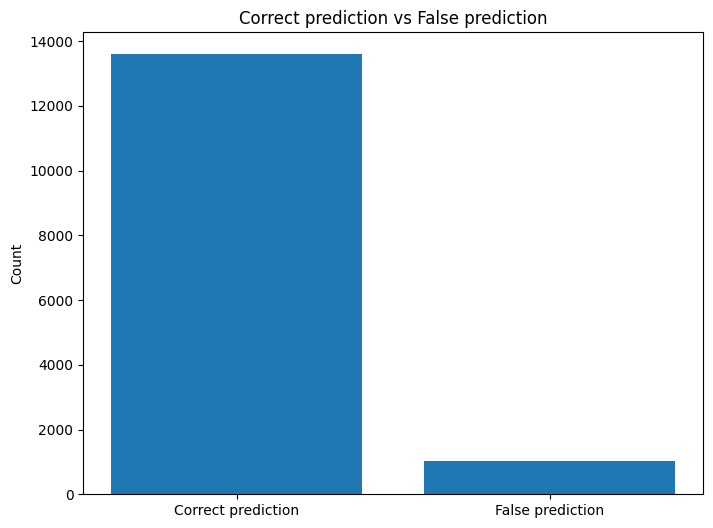

In [19]:
import matplotlib.pyplot as plt

# Assuming df_test has a column named 'correctPred' with boolean values or similar
correct_pred_counts = df_test['correctPred'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Correct prediction', 'False prediction'], correct_pred_counts)
plt.title('Correct prediction vs False prediction')
plt.ylabel('Count')

# Show the plot
plt.show()


## Random Sample Predictions Visualization

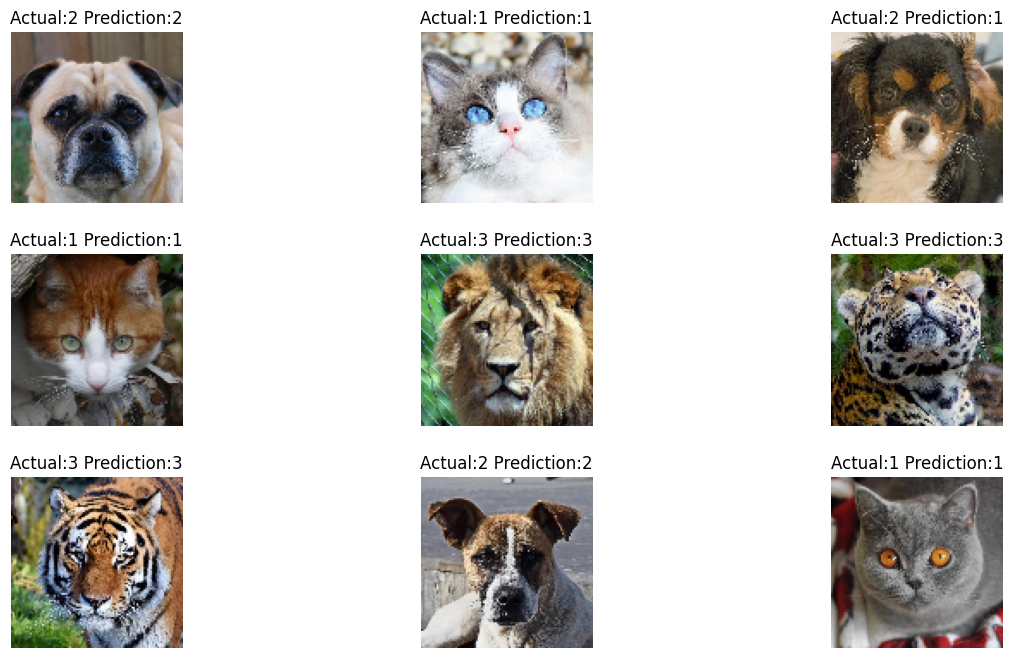

In [20]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import load_img

# Generate random indices
randomlist = []
for i in range(9):
    n = random.randint(0, len(df_test) - 1)
    randomlist.append(n)

# Create a figure and grid spec
fig = plt.figure(figsize=(15, 8))
gs1 = gridspec.GridSpec(3, 3)

# Create subplots and display images
for num, idx in enumerate(randomlist):
    row = df_test.iloc[idx]
    filename = row['filename']
    img = load_img(f"/kaggle/input/animal-faces/afhq/train/{filename}", target_size=(100, 100))
    ax = fig.add_subplot(gs1[num])
    ax.imshow(img)
    ax.set_title(f"Actual:{row['class']} Prediction:{row['prediction']}")
    ax.axis('off')

# Adjust the layout
fig.subplots_adjust(hspace=0.3)
plt.show()


In [21]:
classes = {"cat": "1", "dog": "2", "wild": "3"}
class_mapping = {"1": "cat", "2": "dog" , "3": "wild" }
df_test['class'].replace(class_mapping, inplace=True)
df_test['prediction'].unique()

array([1, 2, '3'], dtype=object)

In [22]:
class_mapping = {1: "cat", 2: "dog" , "3": "wild" }
df_test['prediction'].replace(class_mapping, inplace=True)

In [23]:
df_test

,filename,class,prediction,correctPred
0,cat/pixabay_cat_000354.jpg,cat,cat,True
1,cat/pixabay_cat_002763.jpg,cat,cat,True
2,cat/pixabay_cat_001283.jpg,cat,cat,True
3,cat/pixabay_cat_003423.jpg,cat,cat,True
4,cat/flickr_cat_000496.jpg,cat,cat,True
...,...,...,...,...
14625,wild/pixabay_wild_000618.jpg,wild,dog,False
14626,wild/pixabay_wild_000552.jpg,wild,wild,True
14627,wild/flickr_wild_002275.jpg,wild,wild,True
14628,wild/pixabay_wild_000484.jpg,wild,wild,True


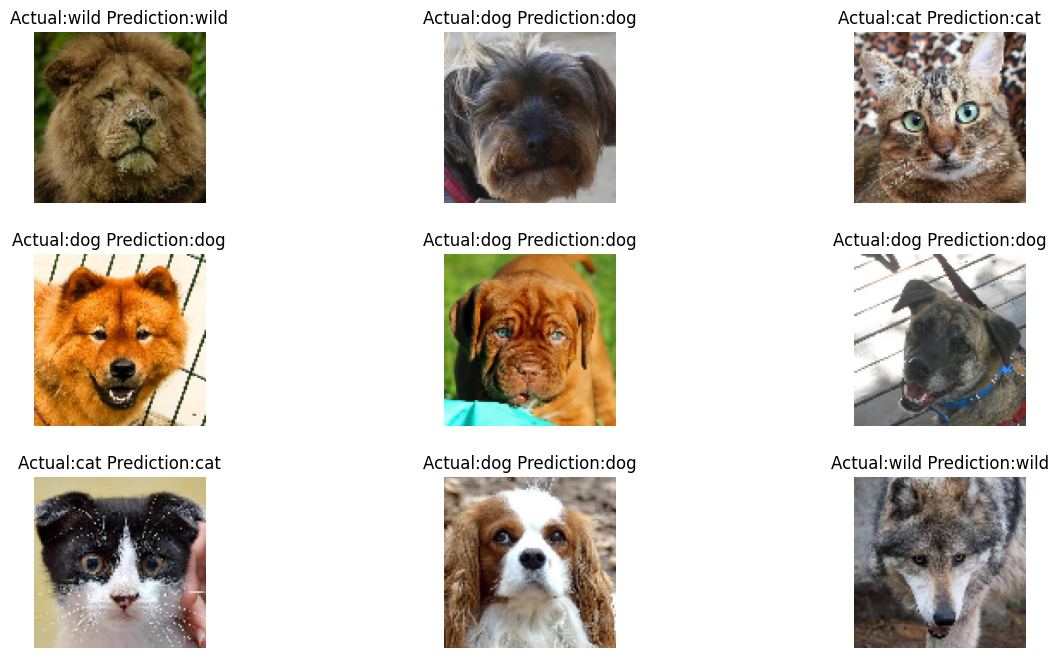

In [24]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import load_img

# Generate random indices
randomlist = []
for i in range(9):
    n = random.randint(0, len(df_test) - 1)
    randomlist.append(n)

# Create a figure and grid spec
fig = plt.figure(figsize=(15, 8))
gs1 = gridspec.GridSpec(3, 3)

# Create subplots and display images
for num, idx in enumerate(randomlist):
    row = df_test.iloc[idx]
    filename = row['filename']
    img = load_img(f"/kaggle/input/animal-faces/afhq/train/{filename}", target_size=(100, 100))
    ax = fig.add_subplot(gs1[num])
    ax.imshow(img)
    ax.set_title(f"Actual:{row['class']} Prediction:{row['prediction']}")
    ax.axis('off')

# Adjust the layout
fig.subplots_adjust(hspace=0.3)
plt.show()
